In [31]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

from matplotlib import rcParams
rcParams['axes.unicode_minus'] = False
rcParams["font.family"] = "serif"
rcParams["font.serif"] = ['cmr10']

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
# matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'cmr10'
rcParams['mathtext.it'] = 'cmr10:italic'
rcParams['mathtext.bf'] = 'cmr10:bold'

In [ ]:
filename = 'checkout_wc_reco2.root'

def get_scores_vars(filename):
    pot_per_evt = 1.944e+20
    overlay = uproot.open(f"samples/{filename}")
    bdt_score = uproot.open(f"samples/bdt_gpu_delta_inputs_noothscores/outputs/{filename}")
    bdt_score_df = bdt_score['tree'].arrays(library='pd')
    

    # Presel
    # "match_found_asInt == 1 && stm_eventtype != 0 && stm_lowenergy ==0 && stm_LM ==0 && stm_TGM ==0 && stm_STM==0 && stm_FullDead == 0 && stm_clusterlength >0

    # Keys for ncPi0 truth definition
    keys_eval = ['run', 'subrun', 'event','match_found_asInt', 'stm_eventtype', 'stm_lowenergy', 'stm_LM', 'stm_TGM', 'stm_STM', 'stm_FullDead', 'stm_clusterlength']
    keys_PF = ['reco_showerKE', 'reco_showerMomentum', ]

    if 'data' not in filename.lower():
        keys_eval += ['match_isFC', 'match_completeness_energy', 'truth_energyInside', 'truth_vtxInside', 'weight_spline','weight_cv']
        keys_PF += ['truth_isCC', 'truth_NprimPio', 'truth_NCDelta']

    eval = overlay['wcpselection/T_eval'].arrays(keys_eval, library='pd')
    pf_eval = overlay['wcpselection/T_PFeval'].arrays(keys_PF, library='pd')
    pf_eval = pd.merge(pf_eval, eval, left_index=True, right_index=True)
    pf_eval = pd.merge(pf_eval, bdt_score_df, left_index=True, right_index=True)
    pf_eval['pot'] = np.ones_like(pf_eval['run']) * len(pf_eval) * pot_per_evt
    print('N before preselection: ', len(pf_eval))
    pf_eval = pf_eval.query('match_found_asInt == 1 & stm_eventtype != 0 & stm_lowenergy ==0 & stm_LM ==0 & stm_TGM ==0 & stm_STM==0 & stm_FullDead == 0 & stm_clusterlength >0')
    print('N after preselection', len(pf_eval))

    return pf_eval

N before preselection:  154
N after preselection 119


N before preselection:  154
N after preselection 119


/tmp/ipykernel_59212/1028478736.py:41: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.stairs(hist, bin_edges, color='r', linestyle='-', lw=3, label=r'$\nu_\mu\rightarrow\nu_\mu e^+e^-$')


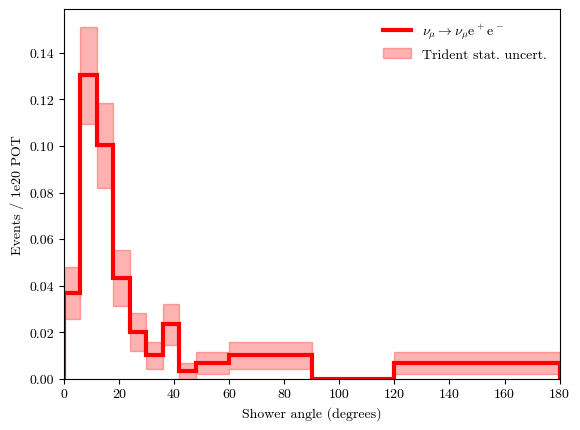

In [233]:
var_to_plot = 'dnu_0p_ang' # dnu_0p_sigcut0, dnu_0p_ene, dnu_0p_ang
sig_cut = 0.9

trident_df = get_scores_vars(filename)

xlabel = (
	'BDT Score' if var_to_plot == 'dnu_0p_sigcut0'
	else 'Shower energy (GeV)' if var_to_plot == 'dnu_0p_ene'
	else 'Shower angle (degrees)' if var_to_plot == 'dnu_0p_ang'
	else ''
)

bins = (
    np.linspace(0, 1, 100) if var_to_plot == 'dnu_0p_sigcut0'
    else np.array([0,6,12,18,24,30,36,42,48,54,60,90,120,180]) if var_to_plot == 'dnu_0p_ang'
    else np.linspace(0, 2, 20) if var_to_plot == 'dnu_0p_ene'
    else np.array([0,1])
)

if var_to_plot == 'dnu_0p_sigcut0':
    trident_df['dnu_0p_sigcut0'] = trident_df['bdt_result']
elif var_to_plot == 'dnu_0p_ene':
    trident_df['dnu_0p_ene'] = trident_df['reco_showerKE']
elif var_to_plot == 'dnu_0p_ang':
    # trident_df['dnu_0p_ang'] = np.degrees(np.arccos(trident_df['reco_showerMomentum'].to_numpy()[:,2] / np.linalg.norm(trident_df['reco_showerMomentum'].to_numpy(), axis=1)))
    angles = [np.degrees(np.arccos(p[2]/p[3])) for p in trident_df['reco_showerMomentum'].to_numpy()]
    trident_df['dnu_0p_ang'] = angles
    

hist, bin_edges = np.histogram(trident_df[var_to_plot], bins=bins)
stat_uncert = np.sqrt(hist)

pot = trident_df['pot'].iloc[0]

hist = hist * 1e20 / pot
stat_uncert = stat_uncert * 1e20 / pot

trident_up = hist + stat_uncert
trident_down = hist - stat_uncert

plt.stairs(hist, bin_edges, color='r', linestyle='-', lw=3, label=r'$\nu_\mu\rightarrow\nu_\mu e^+e^-$')
plt.fill_between(bin_edges, np.append(trident_down, trident_down[-1]),  np.append(trident_up, trident_up[-1]), step='post',alpha=0.3, color='r', label='Trident stat. uncert.')
plt.xlabel(xlabel)
plt.ylabel('Events / 1e20 POT')
plt.legend(ncols=1, framealpha=0.0)
plt.xlim(bin_edges[0], bin_edges[-1])
plt.show()

trident_df = trident_df.query(f'bdt_result > {sig_cut}')

overlay_info = {
            'path': '/exp/uboone/app/users/jbateman/workdir/DarkNews/WCepem/newSamples/comparisons/run_systematics/run1/',
            'POT': 1.42319e+20,
            'name': 'Run 1',
            'filename': 'reprod_full_systs.root'
        }

overlay = uproot.open(f'{overlay_info["path"]}canvases/{var_to_plot}/{overlay_info["filename"]}')




In [234]:
def get_background_with_systs(overlay, cap_uncert=None, stat_only=False):
    cv_dict = {}

    var_keys = []
    for key in overlay.keys():
        if 'cv' in key:
            key_split = str(key).split("/")[1]
            key_split = key_split.split(";")[0]
            if key_split not in var_keys:
                var_keys.append(key_split)
        if 'data' in key:
            print(key)
            key_split = str(key).split(";")[0]
            print(key_split)
            if key_split not in var_keys:
                var_keys.append(key_split)
    
    cv_keys = np.unique(var_keys)

    

    _, temp_hist = overlay.items()[0]
    temp_hist, bin_edges = temp_hist.to_numpy()
    
    cv_dict = {}
    for key in cv_keys:
        var_dict = {
            'hist': np.zeros(len(bin_edges)-1),
            'uncert2': np.zeros(len(bin_edges)-1)
        }
        cv_dict[key] = var_dict

    # Getting the CV and statistical uncertainty
    for branch in overlay.items():
        name, hist = branch
        var = name.split(";")[0]
        if var.split('/')[-1] not in cv_keys:
            print('Skipping ', var)
            continue
        if 'cv/' in name:
            var = str(var).split("/")[1]
            cv_dict[var]['hist'], _ = hist.to_numpy()
            cv_dict[var]['uncert2'] = hist.errors()**2


    for branch in overlay.items():
        name, hist = branch
        var = name.split(";")[0]
        if var.split('/')[-1] not in cv_keys:
            print(f"Variable {var} not found in cv_keys, skipping")
            continue
        if var == 'data':
            cv_dict[var]['hist'], _ = hist.to_numpy()
            cv_dict[var]['uncert2'] = hist.errors()**2
        elif 'cv' not in var and not stat_only:
            var = str(var).split("/")[1]
            var_hist, _ = hist.to_numpy()
            uncert = hist.errors()

            if cap_uncert is not None:
                uncert = np.where(uncert > cap_uncert*var_hist, cap_uncert*var_hist, uncert)
            if var in cv_dict:
                cv_dict[var]['uncert2'] += uncert**2
            else:
                # We should not have any systematics that dont have a CV, so something is wrong
                raise IndexError(f"{var} not found in cv_dict keys")
    return cv_dict, bin_edges, cv_keys

In [235]:
def sort_cv_dict(cv_dict):
    keys = list(cv_dict.keys())

    N_evts = []
    for key in keys:
        N_evts.append(cv_dict[key]['hist'].sum())
    sorted_indices = np.argsort(N_evts)
    sorted_keys = [keys[i] for i in sorted_indices]
    sorted_cv_dict = {key: cv_dict[key] for key in sorted_keys}
    return sorted_cv_dict

cv_dict, bin_edges, var_keys = get_background_with_systs(overlay, cap_uncert=0.5, stat_only=False)
# cv_dict = sort_cv_dict(cv_dict)

data;1
data


In [236]:
trident_df['pot'].iloc[0]

np.float64(2.99376e+22)

Found data


/tmp/ipykernel_59212/2667852070.py:40: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.stairs(tot_hist+var_hist, bin_edges, baseline=tot_hist, fill=True, alpha=0.75, label=var)


(0.0, 180.0)

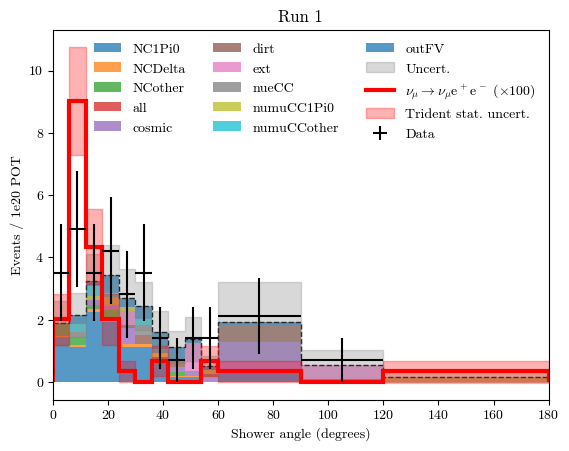

In [ ]:
pot_norm = True

trident_enhancement = 100

tot_cv = np.zeros(len(bin_edges)-1)
tot_uncert2 = np.zeros(len(bin_edges)-1)

tot_hist = np.zeros(len(bin_edges)-1)
tot_uncert2 = np.zeros(len(bin_edges)-1)
data_hist = np.zeros(len(bin_edges)-1)
data_uncert = np.zeros(len(bin_edges)-1)

POT = overlay_info['POT']
name = overlay_info['name']

for j, var in enumerate(var_keys):
    
    if  'data' in var.lower():
        print('Found data')
        centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
        data_hist = cv_dict[var]['hist'].copy()
        data_uncert = np.sqrt(data_hist).copy()
        widths = bin_edges[1:] - bin_edges[:-1]
        zero_mask = data_hist == 0
        

        if pot_norm:
            data_hist /= (POT/1e20)
            data_uncert /= (POT/1e20)

        plt.errorbar(centers[~zero_mask], data_hist[~zero_mask], xerr=widths[~zero_mask]/2, yerr=data_uncert[~zero_mask], fmt=' ', ls=None, color='k', label='Data')
        continue
    var_hist = cv_dict[var]['hist'].copy()
    var_uncert2 = cv_dict[var]['uncert2'].copy()

    if pot_norm:
        var_hist /= (POT/1e20)
        var_uncert2 /= (POT/1e20)**2

    plt.stairs(tot_hist+var_hist, bin_edges, baseline=tot_hist, fill=True, alpha=0.75, label=var)

    tot_hist += var_hist
    tot_uncert2 += var_uncert2

title = f"{name}"
plt.title(title)
plt.stairs(tot_hist, bin_edges, color='k', linestyle='--',)

tot_uncert = np.sqrt(tot_uncert2)
band_up = tot_hist + tot_uncert
band_down = tot_hist - tot_uncert

plt.fill_between(bin_edges, np.append(band_down, band_down[-1]),  np.append(band_up, band_up[-1]), step='post',alpha=0.3, color='gray', label='Uncert.')


# Plotting tridents on top
trident_pot = trident_df['pot'].iloc[0]
trident_hist, _ = np.histogram(trident_df[var_to_plot], bins=bin_edges)
trident_stat_uncert = np.sqrt(trident_hist)

trident_sf = trident_enhancement
if pot_norm:
    trident_sf *= 1e20 / trident_pot
else:
    trident_sf *= POT / trident_pot

trident_up = trident_hist + trident_stat_uncert 
trident_down = trident_hist  - trident_stat_uncert 
plt.stairs(trident_hist * trident_sf, bin_edges, color='r', linestyle='-', lw=3, label=r'$\nu_\mu\rightarrow\nu_\mu e^+e^-$ ($\times$' + str(trident_enhancement) + ')')

plt.fill_between(bin_edges, np.append(trident_down*trident_sf, (trident_down*trident_sf)[-1]),  np.append(trident_up*trident_sf, (trident_up*trident_sf)[-1]), step='post',alpha=0.3, color='r', label='Trident stat. uncert.')

plt.xlabel(xlabel)
plt.ylabel('Events / 1e20 POT')
plt.legend(ncols=3, framealpha=0.0)
plt.xlim(bin_edges[0], bin_edges[-1])
# plt.ylim(0, 10)
plt.show()
